In [1]:
# ! pip install torchsummary
# ! pip install albumentations

In [1]:
from ds_toolkit.general_utils.gpu_utils import addGPU

addGPU()

CUDA environment device set to 0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [4]:
from utils.data import CIFAR10_dataset
from utils.misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class,
    get_wrong_predictions
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import numpy as np
import torchvision

### Device

In [6]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  True
[INFO] device :  cuda


## Data Loader

In [7]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified

        [INFO] train dataset of size 50000 loaded...
        
Files already downloaded and verified

        [INFO] test dataset of size 10000 loaded...
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


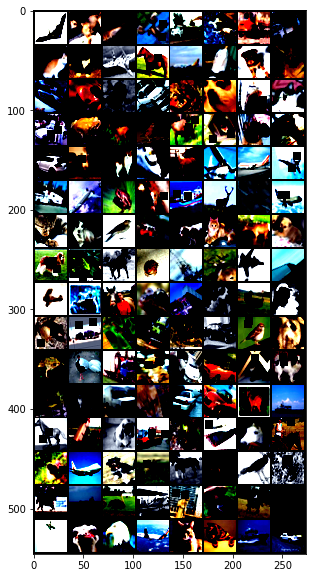

In [8]:
show_random_images(train_loader)

In [11]:
writer = SummaryWriter('./runs/test_tensorboard')

In [20]:
sample_batch = next(iter(train_loader))[0]
sample_img_grid = torchvision.utils.make_grid(sample_batch)
sample_batch.shape[1:]

torch.Size([3, 32, 32])

In [16]:
writer.add_image('normalized_train_images', sample_img_grid)

## Load Model

In [ ]:
experiments= {
    "first_exp": {
        'BN': True, 'GN': False, 'LN': False, 'L1': False, 'L2': False
    },
}
EPOCHS = 100
results = {}
models = {}
for exp_name, exp in experiments.items():
    print("Experiment : ", exp_name)
    results[exp_name] = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch': [],
    }

    net = Net(
        dropout_value=0.2, BN=exp['BN'], GN=exp['GN'], LN=exp['LN']
    ).to(device)
    show_model_summary(net, input_size=sample_batch.shape[1:])
    writer.add_graph(net, sample_batch.to(device))

    weight_decay = 1e-5 if exp['L2'] else 0
    optimizer = optim.SGD(
        net.parameters(), 
        lr=0.015, momentum=0.9, 
        weight_decay=weight_decay
    )
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, 
        patience=3, min_lr=0.0001, verbose=True
    )

    for epoch in range(0, EPOCHS + 1):
        print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
        train_loss_batch, train_acc_batch = train(
            net, device, 
            train_loader, 
            optimizer, 
            lr_scheduler,
            L1=exp['L1']
        )
        
        train_acc = np.mean(train_acc_batch)
        train_loss = np.mean(train_loss_batch)

        test_loss, test_acc = test(
            net, device, 
            test_loader,
            lr_scheduler
        )
        
        writer.add_scalar('train_acc', train_acc, epoch)
        writer.add_scalar('train_loss', train_loss, epoch)
        writer.add_scalar('test_loss', test_loss, epoch)
        writer.add_scalar('test_acc', test_acc, epoch)
        
        for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
            results[exp_name][metric].append(eval(metric))
    
    models[exp_name] = net
writer.close()

Experiment :  first_exp
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
      BatchNorm2d-12           [-1, 64, 32, 32]             128
           Conv2d-13           [-1, 32, 17, 17]           2,080
             Re

  0%|          | 0/391 [00:00<?, ?it/s]

[EPOCH 0 / 100] -- 


Loss=1.5593684911727905 Batch_id=390 Accuracy=31.28: 100%|██████████| 391/391 [00:09<00:00, 40.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5782, Accuracy: 4297/10000 (42.97%)

[EPOCH 1 / 100] -- 


Loss=1.4581366777420044 Batch_id=390 Accuracy=42.97: 100%|██████████| 391/391 [00:09<00:00, 40.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3881, Accuracy: 5039/10000 (50.39%)

[EPOCH 2 / 100] -- 


Loss=1.4030137062072754 Batch_id=390 Accuracy=47.83: 100%|██████████| 391/391 [00:10<00:00, 37.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2336, Accuracy: 5576/10000 (55.76%)

[EPOCH 3 / 100] -- 


Loss=1.4394663572311401 Batch_id=390 Accuracy=50.67: 100%|██████████| 391/391 [00:10<00:00, 37.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2507, Accuracy: 5557/10000 (55.57%)

[EPOCH 4 / 100] -- 


Loss=1.243717908859253 Batch_id=390 Accuracy=52.59: 100%|██████████| 391/391 [00:11<00:00, 32.84it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1799, Accuracy: 5777/10000 (57.77%)

[EPOCH 5 / 100] -- 


Loss=1.3611429929733276 Batch_id=390 Accuracy=54.21: 100%|██████████| 391/391 [00:10<00:00, 36.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0626, Accuracy: 6173/10000 (61.73%)

[EPOCH 6 / 100] -- 


Loss=1.112833023071289 Batch_id=390 Accuracy=55.73: 100%|██████████| 391/391 [00:10<00:00, 38.59it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0689, Accuracy: 6140/10000 (61.40%)

[EPOCH 7 / 100] -- 


Loss=0.9989230036735535 Batch_id=390 Accuracy=57.13: 100%|██████████| 391/391 [00:10<00:00, 37.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0116, Accuracy: 6407/10000 (64.07%)

[EPOCH 8 / 100] -- 


Loss=0.9876385927200317 Batch_id=390 Accuracy=58.30: 100%|██████████| 391/391 [00:10<00:00, 36.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9557, Accuracy: 6581/10000 (65.81%)

[EPOCH 9 / 100] -- 


Loss=1.0468188524246216 Batch_id=390 Accuracy=59.27: 100%|██████████| 391/391 [00:10<00:00, 36.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9559, Accuracy: 6589/10000 (65.89%)

[EPOCH 10 / 100] -- 


Loss=1.185145616531372 Batch_id=390 Accuracy=60.06: 100%|██████████| 391/391 [00:10<00:00, 35.74it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9277, Accuracy: 6766/10000 (67.66%)

[EPOCH 11 / 100] -- 


Loss=1.2711601257324219 Batch_id=390 Accuracy=61.09: 100%|██████████| 391/391 [00:11<00:00, 34.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9309, Accuracy: 6753/10000 (67.53%)

[EPOCH 12 / 100] -- 


Loss=1.1157869100570679 Batch_id=390 Accuracy=61.45: 100%|██████████| 391/391 [00:10<00:00, 36.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9124, Accuracy: 6806/10000 (68.06%)

[EPOCH 13 / 100] -- 


Loss=1.3081495761871338 Batch_id=390 Accuracy=62.32: 100%|██████████| 391/391 [00:11<00:00, 33.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8486, Accuracy: 7003/10000 (70.03%)

[EPOCH 14 / 100] -- 


Loss=1.046357274055481 Batch_id=390 Accuracy=62.59: 100%|██████████| 391/391 [00:10<00:00, 36.86it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8432, Accuracy: 7022/10000 (70.22%)

[EPOCH 15 / 100] -- 


Loss=1.1578527688980103 Batch_id=390 Accuracy=63.20: 100%|██████████| 391/391 [00:11<00:00, 34.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7971, Accuracy: 7212/10000 (72.12%)

[EPOCH 16 / 100] -- 


Loss=0.9578831791877747 Batch_id=390 Accuracy=63.90: 100%|██████████| 391/391 [00:10<00:00, 36.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8095, Accuracy: 7199/10000 (71.99%)

[EPOCH 17 / 100] -- 


Loss=1.1198968887329102 Batch_id=390 Accuracy=64.55: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8121, Accuracy: 7145/10000 (71.45%)

[EPOCH 18 / 100] -- 


Loss=1.0598732233047485 Batch_id=390 Accuracy=64.91: 100%|██████████| 391/391 [00:10<00:00, 36.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7868, Accuracy: 7216/10000 (72.16%)

[EPOCH 19 / 100] -- 


Loss=1.0555788278579712 Batch_id=390 Accuracy=65.47: 100%|██████████| 391/391 [00:10<00:00, 36.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7653, Accuracy: 7345/10000 (73.45%)

[EPOCH 20 / 100] -- 


Loss=1.0313609838485718 Batch_id=390 Accuracy=65.60: 100%|██████████| 391/391 [00:11<00:00, 35.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8053, Accuracy: 7185/10000 (71.85%)

[EPOCH 21 / 100] -- 


Loss=0.93827885389328 Batch_id=390 Accuracy=66.00: 100%|██████████| 391/391 [00:12<00:00, 30.78it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7440, Accuracy: 7400/10000 (74.00%)

[EPOCH 22 / 100] -- 


Loss=0.8402160406112671 Batch_id=390 Accuracy=66.34: 100%|██████████| 391/391 [00:11<00:00, 33.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7530, Accuracy: 7377/10000 (73.77%)

[EPOCH 23 / 100] -- 


Loss=1.0901203155517578 Batch_id=390 Accuracy=66.69: 100%|██████████| 391/391 [00:10<00:00, 36.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7102, Accuracy: 7515/10000 (75.15%)

[EPOCH 24 / 100] -- 


Loss=0.7613964080810547 Batch_id=390 Accuracy=67.14: 100%|██████████| 391/391 [00:10<00:00, 38.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7118, Accuracy: 7537/10000 (75.37%)

[EPOCH 25 / 100] -- 


Loss=0.8699427843093872 Batch_id=390 Accuracy=67.62: 100%|██████████| 391/391 [00:10<00:00, 37.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6906, Accuracy: 7626/10000 (76.26%)

[EPOCH 26 / 100] -- 


Loss=0.6723189949989319 Batch_id=390 Accuracy=67.64: 100%|██████████| 391/391 [00:10<00:00, 37.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7084, Accuracy: 7559/10000 (75.59%)

[EPOCH 27 / 100] -- 


Loss=0.9241713285446167 Batch_id=390 Accuracy=68.28: 100%|██████████| 391/391 [00:10<00:00, 35.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7107, Accuracy: 7550/10000 (75.50%)

[EPOCH 28 / 100] -- 


Loss=0.785184383392334 Batch_id=390 Accuracy=68.38: 100%|██████████| 391/391 [00:10<00:00, 35.69it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6845, Accuracy: 7624/10000 (76.24%)

[EPOCH 29 / 100] -- 


Loss=1.0010507106781006 Batch_id=390 Accuracy=68.37: 100%|██████████| 391/391 [00:10<00:00, 35.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6813, Accuracy: 7674/10000 (76.74%)

[EPOCH 30 / 100] -- 


Loss=0.8101248741149902 Batch_id=390 Accuracy=68.54: 100%|██████████| 391/391 [00:10<00:00, 36.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6590, Accuracy: 7736/10000 (77.36%)

[EPOCH 31 / 100] -- 


Loss=1.0158002376556396 Batch_id=390 Accuracy=69.32: 100%|██████████| 391/391 [00:11<00:00, 35.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6804, Accuracy: 7637/10000 (76.37%)

[EPOCH 32 / 100] -- 


Loss=0.903241753578186 Batch_id=390 Accuracy=69.05: 100%|██████████| 391/391 [00:11<00:00, 32.63it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6834, Accuracy: 7658/10000 (76.58%)

[EPOCH 33 / 100] -- 


Loss=0.6541967988014221 Batch_id=390 Accuracy=69.60: 100%|██████████| 391/391 [00:12<00:00, 30.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6617, Accuracy: 7717/10000 (77.17%)

[EPOCH 34 / 100] -- 


Loss=0.9155551791191101 Batch_id=390 Accuracy=69.78: 100%|██████████| 391/391 [00:09<00:00, 39.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    35: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.6708, Accuracy: 7719/10000 (77.19%)

[EPOCH 35 / 100] -- 


Loss=0.6888835430145264 Batch_id=390 Accuracy=71.07: 100%|██████████| 391/391 [00:10<00:00, 35.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5800, Accuracy: 8008/10000 (80.08%)

[EPOCH 36 / 100] -- 


Loss=0.7510554790496826 Batch_id=390 Accuracy=71.99: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5790, Accuracy: 8011/10000 (80.11%)

[EPOCH 37 / 100] -- 


Loss=0.7250169515609741 Batch_id=390 Accuracy=72.24: 100%|██████████| 391/391 [00:10<00:00, 37.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5696, Accuracy: 8050/10000 (80.50%)

[EPOCH 38 / 100] -- 


Loss=0.9493578672409058 Batch_id=390 Accuracy=72.13: 100%|██████████| 391/391 [00:11<00:00, 35.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5709, Accuracy: 8044/10000 (80.44%)

[EPOCH 39 / 100] -- 


Loss=0.9070420265197754 Batch_id=390 Accuracy=72.18: 100%|██████████| 391/391 [00:14<00:00, 27.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5597, Accuracy: 8110/10000 (81.10%)

[EPOCH 40 / 100] -- 


Loss=0.8439245223999023 Batch_id=390 Accuracy=72.28: 100%|██████████| 391/391 [00:11<00:00, 34.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5655, Accuracy: 8072/10000 (80.72%)

[EPOCH 41 / 100] -- 


Loss=0.8237651586532593 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [00:12<00:00, 32.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5593, Accuracy: 8068/10000 (80.68%)

[EPOCH 42 / 100] -- 


Loss=0.7636429071426392 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [00:11<00:00, 35.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5616, Accuracy: 8068/10000 (80.68%)

[EPOCH 43 / 100] -- 


Loss=0.7505140900611877 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [00:10<00:00, 35.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 8085/10000 (80.85%)

[EPOCH 44 / 100] -- 


Loss=0.7076863050460815 Batch_id=390 Accuracy=72.88: 100%|██████████| 391/391 [00:13<00:00, 28.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5582, Accuracy: 8098/10000 (80.98%)

[EPOCH 45 / 100] -- 


Loss=0.7210243940353394 Batch_id=390 Accuracy=72.88: 100%|██████████| 391/391 [00:11<00:00, 34.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5585, Accuracy: 8081/10000 (80.81%)

[EPOCH 46 / 100] -- 


Loss=0.6852949857711792 Batch_id=390 Accuracy=73.25: 100%|██████████| 391/391 [00:10<00:00, 36.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5564, Accuracy: 8100/10000 (81.00%)

[EPOCH 47 / 100] -- 


Loss=0.8935073018074036 Batch_id=390 Accuracy=73.05: 100%|██████████| 391/391 [00:10<00:00, 38.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5470, Accuracy: 8139/10000 (81.39%)

[EPOCH 48 / 100] -- 


Loss=0.7913035750389099 Batch_id=390 Accuracy=73.30: 100%|██████████| 391/391 [00:12<00:00, 30.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5486, Accuracy: 8121/10000 (81.21%)

[EPOCH 49 / 100] -- 


Loss=0.7280217409133911 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:10<00:00, 37.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5540, Accuracy: 8115/10000 (81.15%)

[EPOCH 50 / 100] -- 


Loss=0.6883112192153931 Batch_id=390 Accuracy=72.91: 100%|██████████| 391/391 [00:11<00:00, 33.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5461, Accuracy: 8144/10000 (81.44%)

[EPOCH 51 / 100] -- 


Loss=0.8112014532089233 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:11<00:00, 35.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5409, Accuracy: 8159/10000 (81.59%)

[EPOCH 52 / 100] -- 


Loss=0.6660960912704468 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:10<00:00, 35.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5452, Accuracy: 8128/10000 (81.28%)

[EPOCH 53 / 100] -- 


Loss=0.8111616373062134 Batch_id=390 Accuracy=73.22: 100%|██████████| 391/391 [00:11<00:00, 34.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5450, Accuracy: 8166/10000 (81.66%)

[EPOCH 54 / 100] -- 


Loss=0.7691994905471802 Batch_id=390 Accuracy=73.35: 100%|██████████| 391/391 [00:11<00:00, 35.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5447, Accuracy: 8128/10000 (81.28%)

[EPOCH 55 / 100] -- 


Loss=0.6831586360931396 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:10<00:00, 37.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    56: reducing learning rate of group 0 to 6.0000e-04.

Test set: Average loss: 0.5461, Accuracy: 8135/10000 (81.35%)

[EPOCH 56 / 100] -- 


Loss=0.9732246398925781 Batch_id=390 Accuracy=73.78: 100%|██████████| 391/391 [00:10<00:00, 38.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5345, Accuracy: 8170/10000 (81.70%)

[EPOCH 57 / 100] -- 


Loss=0.6045950651168823 Batch_id=390 Accuracy=73.80: 100%|██████████| 391/391 [00:11<00:00, 34.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8191/10000 (81.91%)

[EPOCH 58 / 100] -- 


Loss=0.5628648996353149 Batch_id=390 Accuracy=73.70: 100%|██████████| 391/391 [00:10<00:00, 37.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8183/10000 (81.83%)

[EPOCH 59 / 100] -- 


Loss=0.61058509349823 Batch_id=390 Accuracy=74.05: 100%|██████████| 391/391 [00:11<00:00, 35.47it/s]  
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8178/10000 (81.78%)

[EPOCH 60 / 100] -- 


Loss=0.7742363810539246 Batch_id=390 Accuracy=73.87: 100%|██████████| 391/391 [00:10<00:00, 36.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5336, Accuracy: 8195/10000 (81.95%)

[EPOCH 61 / 100] -- 


Loss=0.7688088417053223 Batch_id=390 Accuracy=73.63: 100%|██████████| 391/391 [00:10<00:00, 35.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5309, Accuracy: 8188/10000 (81.88%)

[EPOCH 62 / 100] -- 


Loss=0.6451669931411743 Batch_id=390 Accuracy=74.16: 100%|██████████| 391/391 [00:10<00:00, 35.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8186/10000 (81.86%)

[EPOCH 63 / 100] -- 


Loss=0.646093487739563 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:11<00:00, 35.16it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5302, Accuracy: 8223/10000 (82.23%)

[EPOCH 64 / 100] -- 


Loss=0.7630128860473633 Batch_id=390 Accuracy=74.10: 100%|██████████| 391/391 [00:10<00:00, 36.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8200/10000 (82.00%)

[EPOCH 65 / 100] -- 


Loss=0.7900662422180176 Batch_id=390 Accuracy=73.75: 100%|██████████| 391/391 [00:12<00:00, 31.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5316, Accuracy: 8204/10000 (82.04%)

[EPOCH 66 / 100] -- 


Loss=0.7954917550086975 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [00:13<00:00, 29.67it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    67: reducing learning rate of group 0 to 1.2000e-04.

Test set: Average loss: 0.5321, Accuracy: 8198/10000 (81.98%)

[EPOCH 67 / 100] -- 


Loss=0.878944993019104 Batch_id=390 Accuracy=73.99: 100%|██████████| 391/391 [00:11<00:00, 35.19it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5293, Accuracy: 8208/10000 (82.08%)

[EPOCH 68 / 100] -- 


Loss=0.7455384135246277 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:10<00:00, 36.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5274, Accuracy: 8205/10000 (82.05%)

[EPOCH 69 / 100] -- 


Loss=0.6381748914718628 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:10<00:00, 36.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8224/10000 (82.24%)

[EPOCH 70 / 100] -- 


Loss=0.7486748695373535 Batch_id=390 Accuracy=74.41: 100%|██████████| 391/391 [00:11<00:00, 33.02it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5308, Accuracy: 8197/10000 (81.97%)

[EPOCH 71 / 100] -- 


Loss=0.8753958940505981 Batch_id=390 Accuracy=74.36: 100%|██████████| 391/391 [00:10<00:00, 36.23it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5343, Accuracy: 8193/10000 (81.93%)

[EPOCH 72 / 100] -- 


Loss=0.6120802760124207 Batch_id=390 Accuracy=74.10: 100%|██████████| 391/391 [00:10<00:00, 36.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    73: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.5287, Accuracy: 8197/10000 (81.97%)

[EPOCH 73 / 100] -- 


Loss=0.704951286315918 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:11<00:00, 32.81it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5249, Accuracy: 8228/10000 (82.28%)

[EPOCH 74 / 100] -- 


Loss=1.0037699937820435 Batch_id=390 Accuracy=74.26: 100%|██████████| 391/391 [00:11<00:00, 33.51it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5283, Accuracy: 8213/10000 (82.13%)

[EPOCH 75 / 100] -- 


Loss=0.8199364542961121 Batch_id=390 Accuracy=74.34: 100%|██████████| 391/391 [00:10<00:00, 36.33it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5307, Accuracy: 8217/10000 (82.17%)

[EPOCH 76 / 100] -- 


Loss=0.7220462560653687 Batch_id=390 Accuracy=74.24: 100%|██████████| 391/391 [00:10<00:00, 37.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5311, Accuracy: 8193/10000 (81.93%)

[EPOCH 77 / 100] -- 


Loss=0.7298071384429932 Batch_id=390 Accuracy=74.50: 100%|██████████| 391/391 [00:11<00:00, 33.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5299, Accuracy: 8204/10000 (82.04%)

[EPOCH 78 / 100] -- 


Loss=0.686985969543457 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:11<00:00, 33.38it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5290, Accuracy: 8202/10000 (82.02%)

[EPOCH 79 / 100] -- 


Loss=0.7983052730560303 Batch_id=390 Accuracy=74.04: 100%|██████████| 391/391 [00:10<00:00, 38.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5305, Accuracy: 8191/10000 (81.91%)

[EPOCH 80 / 100] -- 


Loss=0.7768018245697021 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:12<00:00, 30.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5274, Accuracy: 8217/10000 (82.17%)

[EPOCH 81 / 100] -- 


Loss=0.8685259819030762 Batch_id=390 Accuracy=74.14: 100%|██████████| 391/391 [00:11<00:00, 35.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5277, Accuracy: 8207/10000 (82.07%)

[EPOCH 82 / 100] -- 


Loss=0.6226879358291626 Batch_id=390 Accuracy=74.30: 100%|██████████| 391/391 [00:10<00:00, 36.31it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5290, Accuracy: 8201/10000 (82.01%)

[EPOCH 83 / 100] -- 


Loss=0.674219012260437 Batch_id=390 Accuracy=74.29: 100%|██████████| 391/391 [00:13<00:00, 29.69it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5308, Accuracy: 8199/10000 (81.99%)

[EPOCH 84 / 100] -- 


Loss=0.9998296499252319 Batch_id=390 Accuracy=74.38: 100%|██████████| 391/391 [00:11<00:00, 33.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5270, Accuracy: 8225/10000 (82.25%)

[EPOCH 85 / 100] -- 


Loss=0.8675388097763062 Batch_id=390 Accuracy=74.20: 100%|██████████| 391/391 [00:10<00:00, 37.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5295, Accuracy: 8205/10000 (82.05%)

[EPOCH 86 / 100] -- 


Loss=0.7325354218482971 Batch_id=390 Accuracy=74.15: 100%|██████████| 391/391 [00:10<00:00, 36.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5271, Accuracy: 8226/10000 (82.26%)

[EPOCH 87 / 100] -- 


Loss=0.7844366431236267 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:10<00:00, 39.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5275, Accuracy: 8219/10000 (82.19%)

[EPOCH 88 / 100] -- 


Loss=0.8616687059402466 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:11<00:00, 34.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5271, Accuracy: 8211/10000 (82.11%)

[EPOCH 89 / 100] -- 


Loss=0.6720645427703857 Batch_id=390 Accuracy=74.48: 100%|██████████| 391/391 [00:13<00:00, 29.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5287, Accuracy: 8205/10000 (82.05%)

[EPOCH 90 / 100] -- 


Loss=0.6864680051803589 Batch_id=390 Accuracy=74.42: 100%|██████████| 391/391 [00:12<00:00, 31.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5297, Accuracy: 8200/10000 (82.00%)

[EPOCH 91 / 100] -- 


Loss=0.5644564628601074 Batch_id=390 Accuracy=74.07: 100%|██████████| 391/391 [00:10<00:00, 36.70it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5282, Accuracy: 8203/10000 (82.03%)

[EPOCH 92 / 100] -- 


Loss=0.7049993276596069 Batch_id=390 Accuracy=74.29: 100%|██████████| 391/391 [00:10<00:00, 37.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5259, Accuracy: 8224/10000 (82.24%)

[EPOCH 93 / 100] -- 


Loss=0.8681238293647766 Batch_id=390 Accuracy=74.23: 100%|██████████| 391/391 [00:10<00:00, 38.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5305, Accuracy: 8186/10000 (81.86%)

[EPOCH 94 / 100] -- 


Loss=0.8256160020828247 Batch_id=390 Accuracy=74.18: 100%|██████████| 391/391 [00:10<00:00, 38.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5275, Accuracy: 8208/10000 (82.08%)

[EPOCH 95 / 100] -- 


Loss=0.7865214347839355 Batch_id=390 Accuracy=74.36: 100%|██████████| 391/391 [00:10<00:00, 37.72it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5254, Accuracy: 8226/10000 (82.26%)

[EPOCH 96 / 100] -- 


Loss=0.7922322750091553 Batch_id=390 Accuracy=74.45: 100%|██████████| 391/391 [00:10<00:00, 36.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5265, Accuracy: 8212/10000 (82.12%)

[EPOCH 97 / 100] -- 


Loss=0.670698344707489 Batch_id=390 Accuracy=74.37: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5270, Accuracy: 8224/10000 (82.24%)

[EPOCH 98 / 100] -- 


Loss=0.7429551482200623 Batch_id=390 Accuracy=74.23: 100%|██████████| 391/391 [00:10<00:00, 38.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5301, Accuracy: 8206/10000 (82.06%)

[EPOCH 99 / 100] -- 


Loss=0.7387880086898804 Batch_id=390 Accuracy=74.43: 100%|██████████| 391/391 [00:11<00:00, 34.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5272, Accuracy: 8200/10000 (82.00%)

[EPOCH 100 / 100] -- 


Loss=0.6552278399467468 Batch_id=390 Accuracy=74.21: 100%|██████████| 391/391 [00:10<00:00, 38.31it/s]


In [28]:
pd.DataFrame(results['first_exp'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,1.850264,24.549956,1.578187,42.97,0
1,1.560602,41.119217,1.388072,50.39,1
2,1.433943,46.964072,1.233555,55.76,2
3,1.359009,50.159447,1.250665,55.57,3
4,1.317617,52.618930,1.179935,57.77,4
...,...,...,...,...,...
96,0.737906,74.287086,0.526504,82.12,96
97,0.738651,74.676412,0.526964,82.24,97
98,0.739179,74.356202,0.530141,82.06,98
99,0.738410,74.245840,0.527177,82.00,99


In [29]:
exp_results = []
for experiment, result in results.items():
    print(experiment)
    df = pd.DataFrame(result)
    df['experiment_name'] = experiment
    exp_results.append(df)
exp_results_df = pd.concat(exp_results)

first_exp


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style()

Text(0.5, 1, 'Testing Loss')

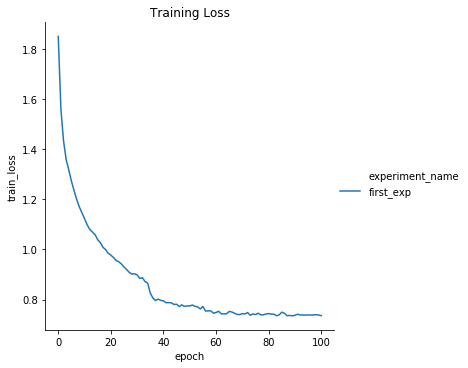

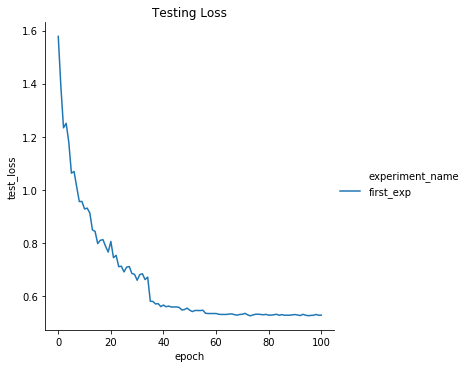

In [32]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_loss', hue='experiment_name')
plt.title("Training Loss")
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_loss', hue='experiment_name')
plt.title("Testing Loss")

Text(0.5, 1, 'Testing Accuracy')

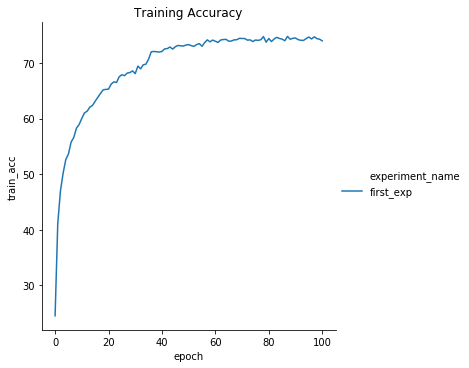

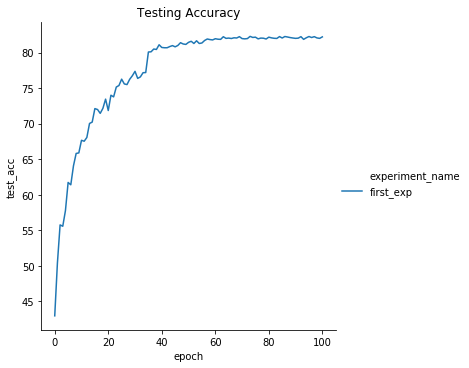

In [33]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_acc', hue='experiment_name')
plt.title("Training Accuracy")
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_acc', hue='experiment_name')
plt.title("Testing Accuracy")

In [34]:
import torch
import torchvision
%matplotlib inline

def get_wrong_predictions(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    wrong_correct = []
    wrong_predicted = []
    wrong_image_data = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            status = pred.eq(target.view_as(pred))
            # correct += status.sum().item()

            mistakes, _ = torch.where(status==False)
            if len(mistakes):
                m_data = data[mistakes]
                m_target = target[mistakes]
                m_output = output[mistakes]
                m_pred = pred[mistakes]
                correct = [x.item() for x in m_target.cpu().detach()]
                predicted = [x.item() for x in m_pred.cpu().detach()]
                image_data = [x for x in m_data.cpu().detach()]

                wrong_correct.extend(correct)
                wrong_predicted.extend(predicted)
                wrong_image_data.extend(image_data)
    
    return wrong_correct, wrong_predicted, wrong_image_data


def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


def show_wrong_images(targets, predicts, images, size=20, grid=(5, 4)):
    img_data_temp = []
    wps = []
    for n, (wc, wp, wi) in enumerate(zip(targets, predicts, images)):
        wps.append(wp)
        img_data_temp.append(wi)
        if n>18:
            break
    
    wrong_images_temp = torch.stack(img_data_temp)
    print()
    print(f"Mistakenly predicted as {wps}")

    grid_img = torchvision.utils.make_grid(wrong_images_temp, nrow=grid[0])
    show_grid(grid_img)

In [35]:
# Find 20 misclassified images for each of the 3 models, and show them as a 5x4 image matrix in 3 separately annotated images. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Mistakenly predicted as [3, 4, 3, 3, 0, 8, 2, 7, 5, 3, 3, 5, 5, 5, 9, 9, 2, 7, 4, 6]


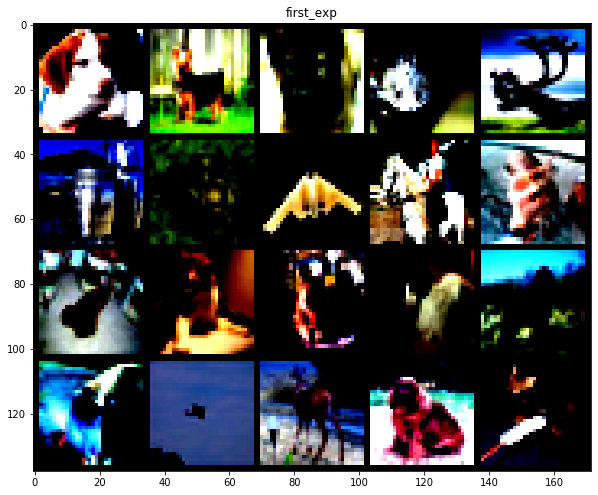

In [37]:
plt.figure(figsize=(10, 10))
targets, predicts, images = get_wrong_predictions(models['first_exp'], test_loader)
show_wrong_images(targets, predicts, images)
plt.title(experiment)
plt.show()